In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import copy
from scipy.optimize import minimize
from IPython.display import HTML
import scipy
from scipy.integrate import odeint

sin = np.sin
cos = np.cos
pi  = np.pi
sqrt = np.sqrt

In [2]:
class TWR ():
    def __init__ (self):
        #robots constants
        self.lin_exp = -2
        self.R  = 10.75 * 10**self.lin_exp      #wheel radius cm
        self.W  = 37.95 * 10**self.lin_exp      #distance between wheels cm
        self.ro = self.W / 2      #half of the distance between wheels 
        self.z  = 33.05 * 10**self.lin_exp      #heigh of the center of mass cm
        self.L  = self.z - self.R      #stick

        self.I_w   = 80    * 10**(2*self.lin_exp)      #wheel's momtent of inertial n/cm2
        self.I_z   = 3305  * 10**(2*self.lin_exp)     #whole robots's moment of inertia around vetrical axis n/cm2
        self.I_psi = 4762  * 10**(2*self.lin_exp)    #whole robots's moment of inertia around axis parallel to wheel's axis n/cm2


        self.mu = 12.55    #Robot's mass with wheels kg
        self.m  = 1.65     #mass of the wheel kg
        self.M  = self.mu - 2 * self.m

        self.g  = 981  * 10**self.lin_exp     #gravity axeliration

        self.u_max = 10000 * 10**(2*self.lin_exp)
        
        self.state = np.zeros (4)
        self.control = 0
        
    def set_state (self, new_state):
        self.state = np.array (new_state)
        
    def set_control (self, control):
        self.control = np.array (control)
        
    def run_sim (self, dt):
        v = self.state

        def calc_I_matrix (v):
            #v - state
            I = 1.0 * np.array ([[ (self.M + 2 * self.m) * self.R**2 + 2 * self.I_w,  self.M * self.R * self.L * cos (v[1])],
                                 [            self.M * self.R * self.L * cos (v[1]),       self.M * self.L**2 + self.I_psi]])
            return I


        def calc_F_matrix (v): 
            
            #v - state
            
            return np.array ([- self.M * self.R * self.L * v[3]**2 * sin (v[1]),  - self.M * self.g * self.L * sin (v[1])])


        H = np.array ([2, -2])


        us = []
        
        u = self.control

        def f (v, t, us=us, u=u):


            I = calc_I_matrix (v)

            I_inv = np.linalg.inv (I)

            F = calc_F_matrix (v)
            

            if u > self.u_max:
                u = self.u_max
            if u < -self.u_max:
                u = -self.u_max


            q_tt = I_inv.dot (H * u - F)
            

            v1 = np.zeros (4)
            v1[:2] = v[2:]
            v1[2:] = q_tt

            return v1
        
        t = np.linspace (0, dt, 3)
        
        vs = odeint (f, self.state, t)[-1]
        
        return vs


In [3]:
def calc_control (state):
    
    gain = [  -2236.07*1.5, -132097.92,   -2752.1*1.5,   -26563.33,]
    
    gain = 20 * np.array (gain)
    
    u = - gain.dot (state)
    
    return u

[0.  0.1 0.  0. ]



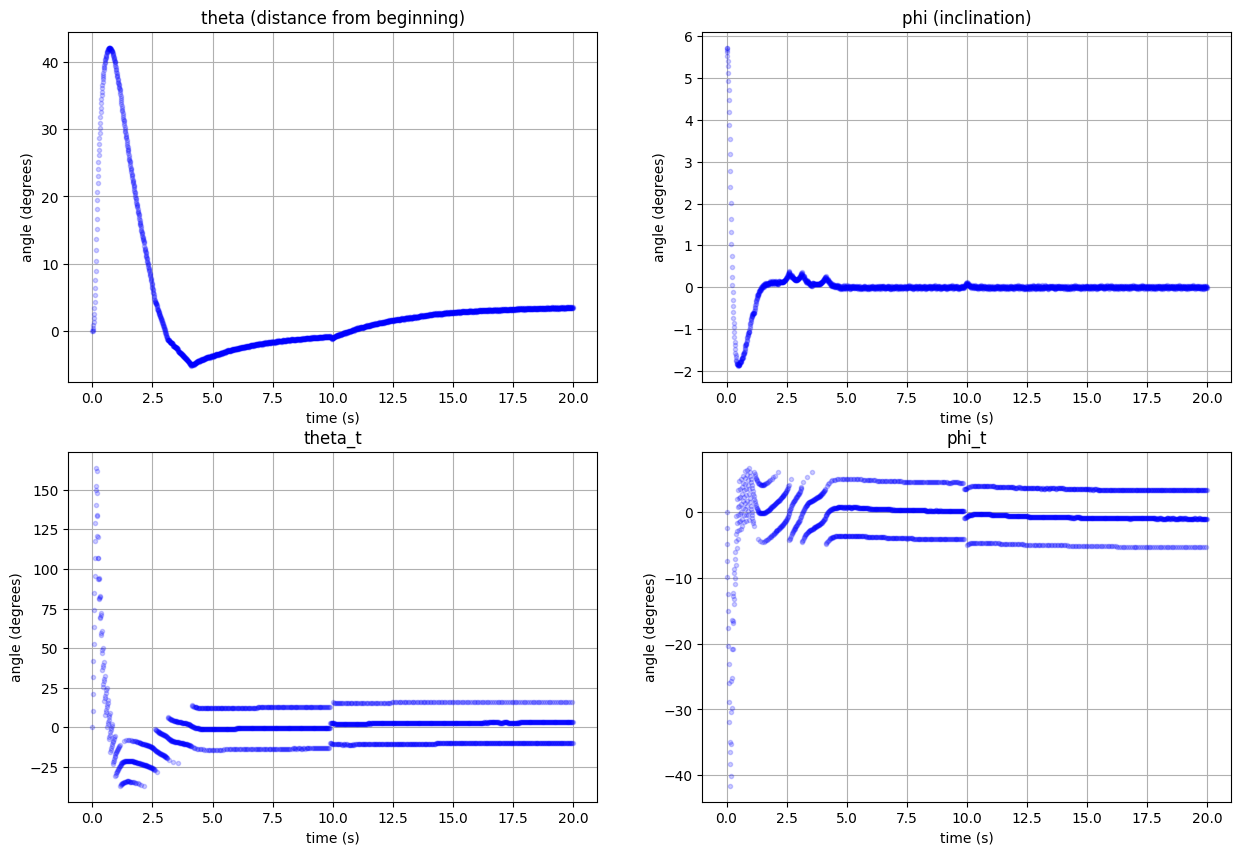

In [6]:
dt = 0.01
twr = TWR ()
twr.set_state ([0, 0.1, 0, 0])
print (twr.state)
print ()


plt.figure (figsize=(15, 10))

for i in range (2000):
    
    state = twr.state
    control = calc_control (state)
    twr.set_control (control)
    new_state = twr.run_sim (dt)
    twr.set_state (new_state)
    
    for j in range (4):
        
        plt.subplot (2, 2, j+1)
        plt.plot (i*dt, 180/pi * state[j], '.', color='b', alpha=0.2)
    

names = ['theta (distance from beginning)', 'phi (inclination)', 'theta_t', 'phi_t']
for j in range (4):
    plt.subplot (2, 2, j+1)
    plt.title (names[j])
    plt.xlabel ('time (s)')
    plt.ylabel ('angle (degrees)')
    plt.grid ()

In [5]:
twr.state

array([ 6.04808220e-02,  7.96937432e-05, -1.72694580e-01,  5.72945006e-02])